# One ring motion (damped rotatoin, without oscillation)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

Epoch 0, Loss: 0.459858, C: 0.101000
Epoch 500, Loss: 0.129881, C: 0.518780
Epoch 1000, Loss: 0.128801, C: 0.627356
Epoch 1500, Loss: 0.128740, C: 0.639858
Epoch 2000, Loss: 0.128730, C: 0.641840
Epoch 2500, Loss: 0.128726, C: 0.642415
Epoch 3000, Loss: 0.128724, C: 0.642565
Epoch 3500, Loss: 0.128723, C: 0.642766
Epoch 4000, Loss: 0.128722, C: 0.642765
Epoch 4500, Loss: 0.128722, C: 0.642809


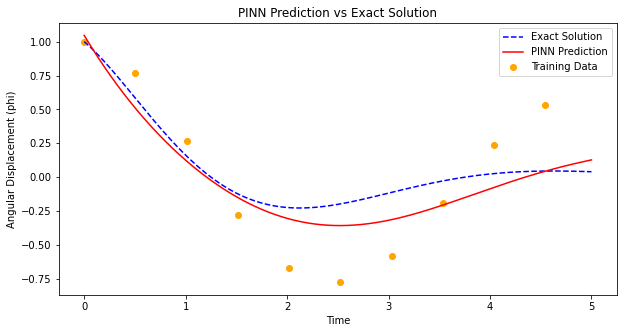

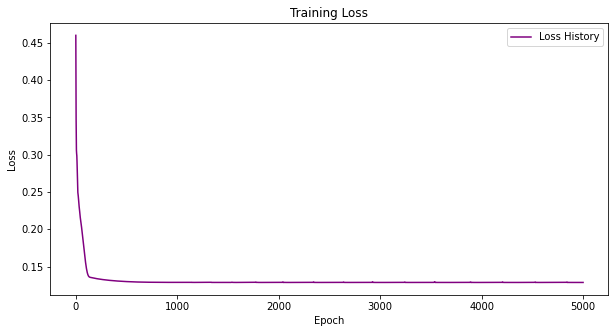

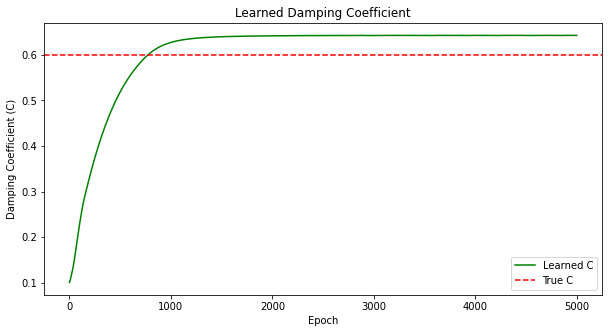

In [7]:
# Define the Physics-Informed Neural Network (PINN) with class form
class PINN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers):
        super(PINN, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(hidden_dim, hidden_dim) for _ in range(num_layers - 1)]
        )
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.activation(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))
        x = self.output_layer(x)
        return x



# Define the governing equation for the problem 
# Here we have no oscillation for one ring as observed in the experiment
def governing_equation(model, x_physics, I, C):
    phi = model(x_physics)
    dphi_dt = torch.autograd.grad(phi, x_physics, torch.ones_like(phi), create_graph=True)[0]
    d2phi_dt2 = torch.autograd.grad(dphi_dt, x_physics, torch.ones_like(dphi_dt), create_graph=True)[0]
    residual = I * d2phi_dt2 + C * dphi_dt
    return residual


# Parameters to be measured in real experiment
I = 1.0  # Moment of inertia to be modified
C = torch.nn.Parameter(torch.tensor(0.1, requires_grad=True))  # Damping coefficient
time_span = 5.0
n_points = 100

# Generate training data
# To be replaced by the real data from the experiment!!!!
t = torch.linspace(0, time_span, n_points).view(-1, 1).requires_grad_(True)
phi_exact = torch.exp(-C.detach() / I * t) * torch.cos(2 * np.pi * t / time_span)

# Training data #### 
x_data = t[::10].detach()
y_data = phi_exact[::10].detach()

#### AFTER MEASUREMENT TO REPLACE BY:
# Load real data
# import pandas as pd
# real_data = pd.read_csv("experimental_data.csv")  # Load the data
# x_data = torch.tensor(real_data['time'].values, dtype=torch.float32).view(-1, 1)
# y_data = torch.tensor(real_data['phi'].values, dtype=torch.float32).view(-1, 1)




# PINN model
hidden_dim = 32
num_layers = 3
model = PINN(input_dim=1, output_dim=1, hidden_dim=hidden_dim, num_layers=num_layers)

# Optimizer
optimizer = torch.optim.Adam(list(model.parameters()) + [C], lr=1e-3)

# Training loop
physics_weight = 1.0
num_epochs = 5000
loss_history = []
C_history = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Data loss
    y_pred = model(x_data)
    data_loss = torch.mean((y_pred - y_data) ** 2)
    
    # Physics loss
    residual = governing_equation(model, t, I, C)
    physics_loss = torch.mean(residual ** 2)
    
    # Total loss
    loss = data_loss + physics_weight * physics_loss
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    C_history.append(C.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}, C: {C.item():.6f}")

# Test data
t_test = torch.linspace(0, time_span, 1000).view(-1, 1)
phi_exact_test = torch.exp(-C.detach() / I * t_test) * torch.cos(2 * np.pi * t_test / time_span)
phi_pred = model(t_test).detach()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(t_test.detach().numpy(), phi_exact_test.detach().numpy(), label="Exact Solution", linestyle="--", color="blue")
plt.plot(t_test.detach().numpy(), phi_pred.detach().numpy(), label="PINN Prediction", color="red")
plt.scatter(x_data.numpy(), y_data.numpy(), label="Training Data", color="orange")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Angular Displacement (phi)")
plt.title("PINN Prediction vs Exact Solution")
plt.show()

# Plot loss history
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label="Loss History", color="purple")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

# Plot learned damping coefficient
plt.figure(figsize=(10, 5))
plt.plot(C_history, label="Learned C", color="green")
plt.axhline(y=0.6, color="red", linestyle="--", label="True C")
plt.xlabel("Epoch")
plt.ylabel("Damping Coefficient (C)")
plt.title("Learned Damping Coefficient")
plt.legend()
plt.show()


# Two rings motion (damped Oscillation)

In [1]:


# Define the Physics-Informed Neural Network (PINN)
class PINN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers):
        super(PINN, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(hidden_dim, hidden_dim) for _ in range(num_layers - 1)]
        )
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.activation(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))
        x = self.output_layer(x)
        return x

# Define the governing equations for the coupled system of two rings
# here we have oscillation and the equation is different ( should we change the equation?)
def governing_equation(model, t, I1, I2, k_rest, C):
    """Physics-based loss function for coupled rotational dynamics."""
    # Predictions for phi1 and phi2
    phi1 = model(t)[:, 0:1]  # First ring's angular displacement
    phi2 = model(t)[:, 1:2]  # Second ring's angular displacement

    # First derivatives (angular velocities)
    dphi1_dt = torch.autograd.grad(phi1, t, torch.ones_like(phi1), create_graph=True)[0]
    dphi2_dt = torch.autograd.grad(phi2, t, torch.ones_like(phi2), create_graph=True)[0]

    # Second derivatives (angular accelerations)
    d2phi1_dt2 = torch.autograd.grad(dphi1_dt, t, torch.ones_like(dphi1_dt), create_graph=True)[0]
    d2phi2_dt2 = torch.autograd.grad(dphi2_dt, t, torch.ones_like(dphi2_dt), create_graph=True)[0]

    # Coupled equations of motion
    residual1 = I1 * d2phi1_dt2 + C * dphi1_dt + k_rest * (phi1 - phi2)
    residual2 = I2 * d2phi2_dt2 + C * dphi2_dt - k_rest * (phi1 - phi2)

    return residual1, residual2

# Define parameters for the simulation
# to be modified!
I1 = 1.0  # Moment of inertia of the first ring (arbitrary units)
I2 = 0.8  # Moment of inertia of the second ring (arbitrary units)
k_rest = 0.5  # Restoring coefficient (arbitrary units)
C = torch.nn.Parameter(torch.tensor(0.1, requires_grad=True))  # Damping coefficient (to be learned)
time_span = 10.0  # Total time for simulation
n_points = 100  # Number of points for training

# Generate training data (synthetic for now)
t = torch.linspace(0, time_span, n_points).view(-1, 1).requires_grad_(True)  # Time points
phi1_exact = torch.cos(2 * np.pi * t / time_span)  # First ring's exact solution (example)
phi2_exact = 0.5 * torch.cos(2 * np.pi * t / time_span - np.pi / 6)  # Second ring's exact solution (example)

# Training data points
x_data = t[::10]
y_data = torch.cat((phi1_exact[::10], phi2_exact[::10]), dim=1)

# Define the PINN model
hidden_dim = 32
num_layers = 3
model = PINN(input_dim=1, output_dim=2, hidden_dim=hidden_dim, num_layers=num_layers)

# Define optimizer
optimizer = torch.optim.Adam(list(model.parameters()) + [C], lr=1e-3)

# Training loop
physics_weight = 1.0  # Weight for the physics-based loss
num_epochs = 5000
loss_history = []
C_history = []

for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Data loss (mean squared error)
    y_pred = model(x_data)
    data_loss = torch.mean((y_pred - y_data) ** 2)

    # Physics loss (residuals of the governing equations)
    residual1, residual2 = governing_equation(model, t, I1, I2, k_rest, C)
    physics_loss = torch.mean(residual1 ** 2) + torch.mean(residual2 ** 2)

    # Total loss
    loss = data_loss + physics_weight * physics_loss
    loss.backward(retain_graph=True)  # Retain the graph to allow multiple backward passes
    optimizer.step()

    loss_history.append(loss.item())
    C_history.append(C.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}, C: {C.item():.6f}")

# Plot the results
t_test = torch.linspace(0, time_span, 1000).view(-1, 1)
phi1_pred, phi2_pred = model(t_test).detach().chunk(2, dim=1)

plt.figure(figsize=(10, 5))
plt.plot(t_test.detach().numpy(), phi1_pred.detach().numpy(), label="PINN Prediction: Ring 1", color="red")
plt.plot(t_test.detach().numpy(), phi2_pred.detach().numpy(), label="PINN Prediction: Ring 2", color="green")
plt.scatter(x_data.detach().numpy(), y_data[:, 0].detach().numpy(), label="Training Data: Ring 1", color="orange")
plt.scatter(x_data.detach().numpy(), y_data[:, 1].detach().numpy(), label="Training Data: Ring 2", color="blue")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Angular Displacement (phi)")
plt.title("PINN Prediction vs Training Data")
plt.show()

# Plot the loss history
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label="Loss History", color="purple")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

# Plot the learned C value
plt.figure(figsize=(10, 5))
plt.plot(C_history, label="Learned C", color="green")
plt.axhline(y=0.1, color="red", linestyle="--", label="True C")
plt.xlabel("Epoch")
plt.ylabel("Damping Coefficient (C)")
plt.title("Learned Damping Coefficient")
plt.legend()
plt.show()


NameError: name 'nn' is not defined